In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sql_query = 'SELECT date, prcp FROM measurement ' \
            'WHERE date > ?'

# Calculate the date 1 year ago from the last data point in the database
last_date = dt.datetime.strptime(session.query(func.max(Measurement.date)).all()[0][0], '%Y-%m-%d')
previous_year = last_date - dt.timedelta(weeks=52)


# Perform a query to retrieve the data and precipitation scores
precipitation_info = pd.read_sql_query(sql_query, conn, 
                                       params=[previous_year.strftime('%Y%m%d')]).dropna()
precipitation_info['date'] = precipitation_info['date'].astype('datetime64[ns]')

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_info.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_info.index.sort_values('date')
precipitation_info.head()

,prcp
date,
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0


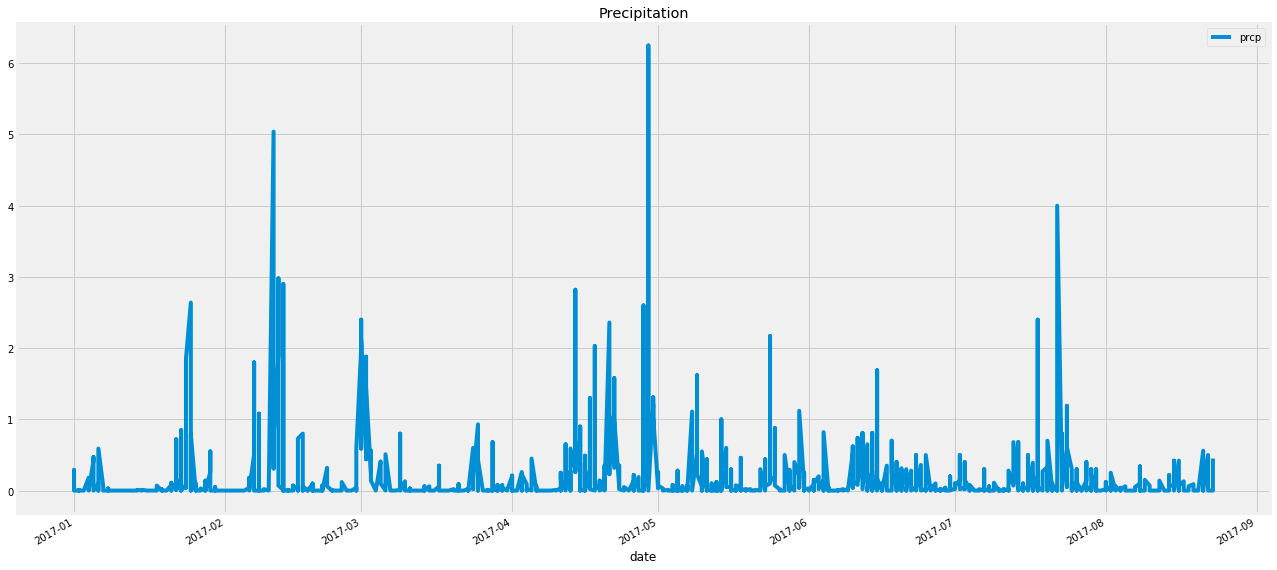

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

precipitation_info.plot(ax=ax, kind='line')
plt.title('Precipitation')
ax.xaxis_date()



![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_info.describe()


,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).one()[0]
station_count


9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station) \
                            .order_by(func.count(Measurement.id).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
tobs_summary = session.query(Measurement.station, func.min(Measurement.tobs), 
                             func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                            .filter(Measurement.station == 'USC00519281').one()
tobs_summary

('USC00519281', 54.0, 85.0, 71.66378066378067)

Text(0.5,1,'Temperatures Observered')

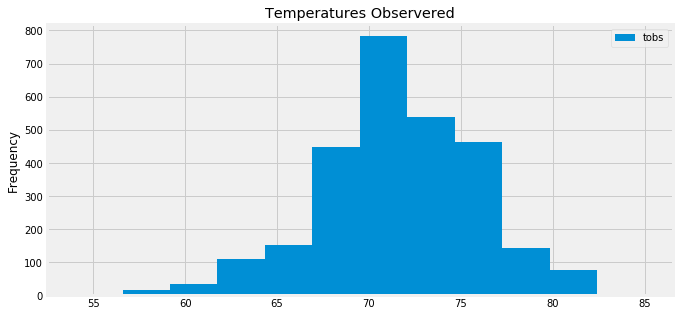

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sql_query_temps = 'SELECT date, tobs ' \
                    'FROM measurement WHERE station IN (' \
                    'SELECT S.station FROM station S ' \
                    'JOIN measurement M ON S.station = M.station ' \
                    'GROUP BY S.station ' \
                    'ORDER BY COUNT(*) DESC ' \
                    'LIMIT 1)'
station_temps = pd.read_sql_query(sql_query_temps, conn)
station_temps['date'] = station_temps['date'].astype('datetime64[ns]')
station_temps.set_index('date', inplace=True)
station_temps.head()

station_temps.plot(kind='hist', figsize=(10, 5), bins=12)
plt.title('Temperatures Observered')


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

data = pd.DataFrame(calc_temps(last_date - dt.timedelta(weeks=1), last_date), columns=['low', 'high', 'average'])
data


,low,high,average
0,71.0,79.0,85.0


Text(0.5,1,'Trip Avg Temp')

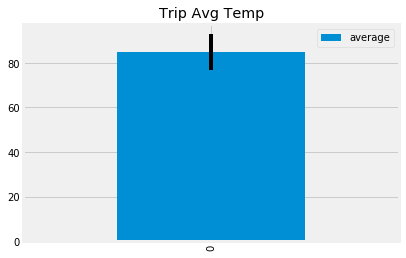

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = data['high'] - data['low']
data.plot(kind='bar', y='average', yerr=yerr)
plt.title('Trip Avg Temp')


In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
from sqlalchemy.sql import and_, or_, not_

year_before_vacay_start = last_date - dt.timedelta(weeks=53)
year_before_vacay_end = year_before_vacay_start + dt.timedelta(weeks=1)

results = session.query(Measurement).filter(and_(Measurement.date >= year_before_vacay_start,
                                               Measurement.date <= year_before_vacay_end)).all()

for result in results:
    print(f'{result.date}, {result.station}, {result.prcp}')

2016-08-18, USC00519397, 0.0
2016-08-19, USC00519397, 0.04
2016-08-20, USC00519397, 0.0
2016-08-21, USC00519397, 0.12
2016-08-22, USC00519397, 0.4
2016-08-23, USC00519397, 0.0
2016-08-24, USC00519397, 0.08
2016-08-18, USC00513117, 0.0
2016-08-19, USC00513117, 0.14
2016-08-20, USC00513117, 0.03
2016-08-21, USC00513117, 0.32
2016-08-22, USC00513117, 0.94
2016-08-23, USC00513117, 0.15
2016-08-24, USC00513117, 2.15
2016-08-18, USC00514830, 0.01
2016-08-19, USC00514830, 0.07
2016-08-20, USC00514830, 0.0
2016-08-22, USC00514830, None
2016-08-23, USC00514830, 0.05
2016-08-24, USC00514830, 2.28
2016-08-18, USC00517948, 0.0
2016-08-22, USC00517948, None
2016-08-23, USC00517948, None
2016-08-24, USC00517948, None
2016-08-18, USC00519523, 0.0
2016-08-19, USC00519523, 0.0
2016-08-20, USC00519523, 0.0
2016-08-21, USC00519523, 0.41
2016-08-22, USC00519523, 0.4
2016-08-23, USC00519523, 0.02
2016-08-24, USC00519523, 1.22
2016-08-18, USC00519281, 0.0
2016-08-19, USC00519281, 0.31
2016-08-20, USC0051928